# Plot bar chart comparing fluid compositions

In [233]:
%load_ext autoreload
%autoreload 2
#%run ct_data.py '../crunchtope_model/hydrothermal_crunch.nc' -c pH totcon
%run pf_data.py '../pflo_revisions/hydrothermal.h5'
%run figures.py
import cmcrameri.cm as cm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}


In [234]:
vent_fluid = {'H+': 6.31e-5, 'Mg++': 1.0e-12, 'Ca++': 40e-3, 'HCO3-': 2.0e-8, 'SO4--': 1e-6, 'SiO2(aq)': 2.02e-2, 'Na+': 0.497}
seawater = {'H+': 10**(-8.15), 'Mg++': 0.0528, 'Ca++': 0.0103, 'HCO3-': 0.002, 'SO4--': 0.0282, 'SiO2(aq)': 0, 'Na+': 0.475}

In [235]:
#pf_data = pf_data.sel(file_number=6)

# Prepend 'Total_' to each key and return as a list
pf_keys = ['Total_' + key for key in vent_fluid.keys()]
pf_keys.remove('Total_H+')
pf_keys.append('pH')
pf_vals = pf_data.isel(z=[35]).sel(x=[0], time=1000, method='nearest')[pf_keys].mean()

data_vars = ['Total_Na+', 'Total_Mg++', 'Total_Ca++', 'Total_HCO3-', 'Total_SO4--', 'Total_SiO2(aq)', 'pH']
# Convert values of each variable to a list
pf_dict = {var: pf_vals[var].values.tolist() for var in data_vars}
# Output the result
pf_values = list(pf_dict.values())
pf_values = np.array(pf_values) * 1000
pf_values = pf_values.flatten()
pf_values[-1] = pf_values[-1] / 1000

In [236]:
pf_dict

{'Total_Na+': 0.37807069135408533,
 'Total_Mg++': 1.965132784082257e-05,
 'Total_Ca++': 0.06326001521581655,
 'Total_HCO3-': 0.00013418227760639832,
 'Total_SO4--': 0.00014671448731101185,
 'Total_SiO2(aq)': 0.00928315391885808,
 'pH': 5.432343851283021}

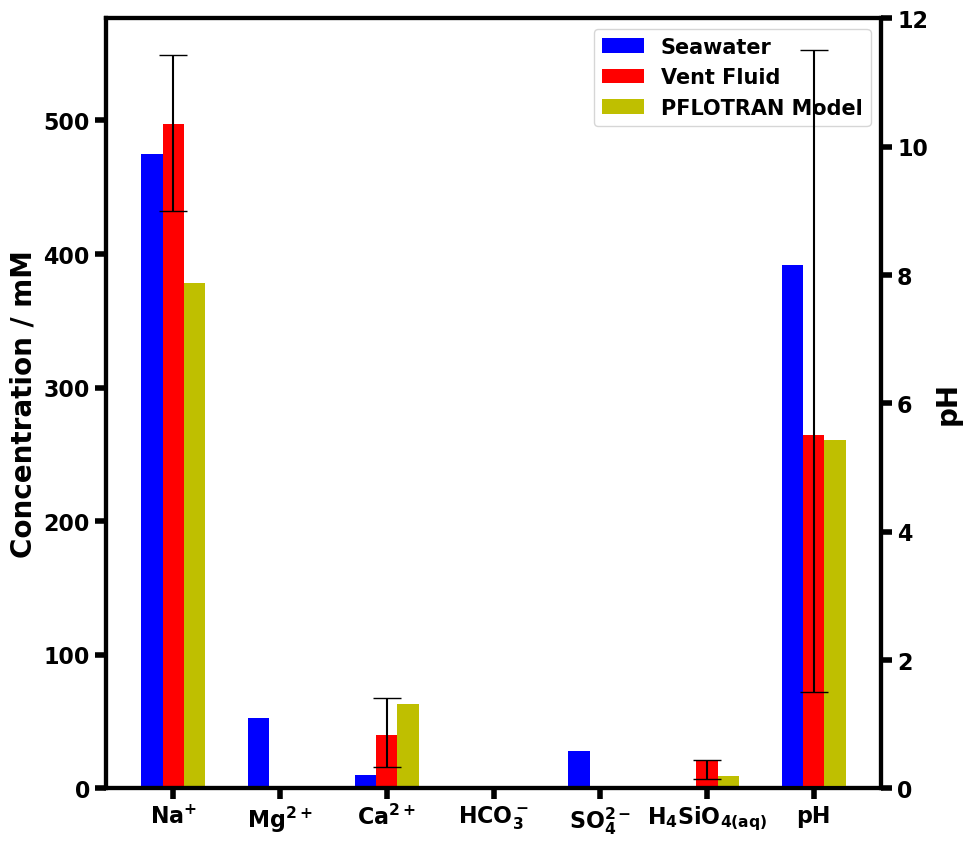

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set global plot parameters
mpl.rcParams['axes.linewidth'] = 3

# Create figure and primary axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(False)
ax.tick_params(length=8, width=4)

# Create the secondary axis for pH and set its styles
ax2 = ax.twinx()
ax2.set_ylim(0, 8)
ax2.set_ylabel('pH', size=20, weight='bold')

# Helper function to set tick label styles
def set_tick_styles(axis, fontsize, fontweight):
    for tick in axis.get_major_ticks():
        tick.label1.set_fontweight(fontweight)
        tick.label1.set_fontsize(fontsize)
        tick.label2.set_fontweight(fontweight)

set_tick_styles(ax.xaxis, 16, 'bold')
set_tick_styles(ax.yaxis, 16, 'bold')
set_tick_styles(ax2.yaxis, 20, 'bold')

# Define chemical species for the x-axis labels
chemical_species = [
    'Na$^{\\mathbf{+}}$', 'Mg$^{\\mathbf{2+}}$', 'Ca$^{\\mathbf{2+}}$', 
    'HCO$\\mathbf{_3^-}$', 'SO$\\mathbf{_4^{2-}}$', 'H$\\mathbf{_4}$SiO$\\mathbf{_{4(aq)}}$', 'pH'
]

# Data for different fluid types; pf_values is assumed to be defined as a numpy array
chemistry_data = {
    'Seawater': np.array([475, 52.8, 10.3, 2.02, 28.2, 0, 8.15]),
    'Vent Fluid': np.array([497, 0, 40, 0, 0, 20.2, 5.5]),
    'PFLOTRAN Model': np.array(pf_values)
}

# Define error bar limits for the Vent Fluid data
vent_data = chemistry_data['Vent Fluid']
vent_lower_bounds = np.array([432, 0, 16, 0, 0, 7.3, 1.5])
vent_upper_bounds = np.array([549, 0, 67.7, 0, 0, 21, 11.5])
error_lower = vent_data - vent_lower_bounds
error_upper = vent_upper_bounds - vent_data
error_limits = np.vstack((error_lower, error_upper))  # shape (2, n_species)

# Bar plot settings
num_species = len(chemical_species)   # 7 species
x_positions = np.arange(num_species)    # positions 0 ... 6
bar_width = 0.2

# Colors and hatch patterns for each dataset
colors = ['b', 'r', 'y']  # one for each dataset
hatches = [None, None, None]

# Plot bars for non-pH data (indices 0 to 5) on the primary axis,
# and plot the pH data (index 6) on the secondary axis.
for idx, (label, data) in enumerate(chemistry_data.items()):
    offset = idx * bar_width

    # Plot non-pH data on primary axis (indices 0 to 5)
    ax.bar(x_positions[:-1] + offset, data[:-1], bar_width, 
           label=label, color=colors[idx], hatch=hatches[idx])
    
    # For Vent Fluid, add error bars for non-pH data
    if label == 'Vent Fluid':
        ax.errorbar(x_positions[:-1] + offset, data[:-1], 
                    yerr=error_limits[:, :-1], fmt='none', c='k', capsize=10)
    
    # Plot pH data (index 6) on secondary axis
    ax2.bar(x_positions[-1] + offset, data[-1], bar_width, 
            label=label if idx == 0 else None, color=colors[idx], hatch=hatches[idx])
    
    # For Vent Fluid, add error bar for pH.
    # Reshape the error limits to have shape (2, 1) so that it matches the single data point.
    if label == 'Vent Fluid':
        ax2.errorbar(x_positions[-1] + offset, data[-1], 
                     yerr=error_limits[:, -1].reshape(2, 1), fmt='none', c='k', capsize=10)

# Set the primary y-axis label and x-axis tick labels (shared by both axes)
ax.set_ylabel('Concentration / mM', size=20, weight='bold')
ax.set_xticks(x_positions + bar_width)  # adjust ticks to center the groups
ax.set_xticklabels(chemical_species)
ax2.set_ylim(0, 12)  # Set the y-limits for the secondary axis
ax2.tick_params(length=8, width=4, labelsize=16, labelcolor='black')

# Add a legend using the primary axis handles
ax.legend(loc='upper right', ncols=1, prop={'weight': 'bold', 'size': 15})

# Save the figure
fig.savefig('output/figure_s2.png', dpi=300)
